In [1]:
import numpy as np
import pandas as pd
import pypsa
import matplotlib.pyplot as plt
from unyt import MWh, kWh

## PyPSA Network

In [2]:
n = pypsa.Network(name='Armourdale')

N_days=365
N_hours=24

index = pd.date_range(start="2018-01-01", 
                      periods=N_days*N_hours, 
                      freq='h')

n.set_snapshots(index)

Step 1: Add buses

In [3]:
bus_name = 'Residential'
n.add(class_name='Bus',
      name=bus_name,
      carrier='AC')

Index(['Residential'], dtype='object')

Step 2: Add energy carriers

In [12]:
n.add(class_name="Carrier", name="grid")
n.add(class_name="Carrier", name="solar")
n.add(class_name="Carrier", name="battery")
n.add(class_name="Carrier", name='net metering')

Index(['net metering'], dtype='object')

Step 3: Add load

In [13]:
load = pd.read_csv("../data/timeseries/residential_elec_load_rescaled.csv", parse_dates=True, index_col='timestamp')

In [14]:
load_resampled = load.loc['2018'].resample('h').mean().sum(axis=1)
load_resampled = load_resampled / 1e3  # kW --> MW

In [16]:
n.add(
    class_name="Load",
    name=f"Load {bus_name}",
    bus=bus_name,
    p_set=load_resampled
)

Index(['Load Residential'], dtype='object')

Step 3: Add weather data

In [17]:
weather = pd.read_csv("../data/timeseries/weather_year.csv", parse_dates=True, index_col=0)
weather.head()

,date_time,temp_db,rel_humidity,wind_speed,wind_direction,ghi,dni,dhi
2018-01-01 00:00:00,2005-01-01 01:00:00,8.0,61,5.7,80,0,0,0
2018-01-01 01:00:00,2005-01-01 02:00:00,8.0,57,5.1,90,0,0,0
2018-01-01 02:00:00,2005-01-01 03:00:00,8.0,57,5.1,90,0,0,0
2018-01-01 03:00:00,2005-01-01 04:00:00,7.0,56,6.2,80,0,0,0
2018-01-01 04:00:00,2005-01-01 05:00:00,7.0,56,5.1,90,0,0,0


In [18]:
# normalize GHI
ghi = weather['ghi'] / weather['ghi'].max()

Step 4: Upload cost data

In [19]:
costs = pd.read_csv("../data/technology_costs.csv", index_col='technology')

In [20]:
costs *= 1e3  # convert /kW to /MW
costs

,Fixed O&M,OCC
technology,,
DistributedWind,35912.100000,5.678577e+06
ResPV,28108.825392,2.630889e+06
Residential Battery Storage,78943.789878,3.157752e+06


Step 5: Add generators to network

In [21]:
def annuity(r, n):
    return r / (1 - 1 / (1 + r)**n)

In [22]:
annuity_adj = annuity(0.07, 20)
annuity_adj

0.09439292574325567

In [23]:
costs = costs.assign(annualized_cost = costs['OCC']*annuity_adj + costs['Fixed O&M'])
costs

,Fixed O&M,OCC,annualized_cost
technology,,,
DistributedWind,35912.100000,5.678577e+06,571929.570926
ResPV,28108.825392,2.630889e+06,276446.116985
Residential Battery Storage,78943.789878,3.157752e+06,377013.201712


In [24]:
for generator in costs.index:
    if generator == 'DistributedWind':
        pass
    else:
        print(generator)
        annualized_cost = costs.at[generator, 'annualized_cost']
        print(annualized_cost)
        
        if generator=='ResPV':
            n.add(class_name='Generator',
                    name=generator,
                    bus=bus_name,
                    carrier="solar",
                    capital_cost=annualized_cost,  # $/kW
                    p_min_pu=ghi,
                    p_max_pu=ghi,
                    p_nom_extendable=True,
                    p_nom_max = 2.807,
                    )
        elif generator=='Residential Battery Storage':
            pass
            n.add(class_name="StorageUnit",
                    name=generator,
                    bus=bus_name,
                    carrier="battery",
                    capital_cost=annualized_cost,  # $/kW
                    p_nom_extendable=True,
                    max_hours=2.5,
                    cyclic_state_of_charge=False,
                    )
        
        

ResPV
276446.11698458303
Residential Battery Storage
377013.20171200635


Add a "net metering" technology to capture the excess energy.

In [25]:
# retail_price = 112.9  # $/MWh
retail_price = 153.4  # $/MWh

In [26]:
n.add(class_name="Generator",
      name=f"Net metering {bus_name}",
      bus=bus_name,
      carrier='net metering',
      p_min_pu=-1,
      p_max_pu=0.0,
      marginal_cost=retail_price*0.0,
      capital_cost=0.0,
      p_nom_extendable=True)

Index(['Net metering Residential'], dtype='object')

In [27]:
n.add(class_name='Generator',
      name='Evergy Import',
      bus=bus_name,
      carrier='grid',
      capital_cost=0,
      marginal_cost=retail_price,
      p_nom_extendable=True,
      # p_nom_max=1.3315
      )

Index(['Evergy Import'], dtype='object')

In [28]:
n.generators

,bus,control,type,p_nom,p_nom_mod,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,...,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,weight,p_nom_opt
Generator,,,,,,,,,,,,,,,,,,,,,
ResPV,Residential,PQ,,0.0,0.0,True,0.0,2.807,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
Net metering Residential,Residential,PQ,,0.0,0.0,True,0.0,inf,-1.0,0.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
Evergy Import,Residential,PQ,,0.0,0.0,True,0.0,inf,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0


## Model Version: Baseline

At this moment, the model

* uses the sticker price for rooftop solar from NREL's ATB
* does NOT pay for net metering
* does NOT include residential storage

Step 6: Run the model

In [29]:
n.optimize(solver_name='highs')

Index(['Residential'], dtype='object', name='Bus')
Index(['Residential'], dtype='object', name='Bus')
c:\Users\SDotson\AppData\Local\miniforge3\envs\pypsa-illinois02\Lib\site-packages\linopy\common.py:147: UserWarning:

coords for dimension(s) ['Generator'] is not aligned with the pandas object. Previously, the indexes of the pandas were ignored and overwritten in these cases. Now, the pandas object's coordinates are taken considered for alignment.

INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 83.61it/s]
INFO:linopy.io: Writing time: 0.62s
INFO:linopy.solvers:Log file at C:\Users\SDotson\AppData\Local\Temp\highs.log
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52564 primals, 122648 duals
Objective: 4.67e+05
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints G

('ok', 'optimal')

In [30]:
results_1 = n.statistics().copy()
results_1

,,Optimal Capacity,Installed Capacity,Supply,Withdrawal,Energy Balance,Transmission,Capacity Factor,Curtailment,Capital Expenditure,Operational Expenditure,Revenue,Market Value
Generator,grid,1.05305,0.0,3044.00579,0.00000,3044.00579,0.0,0.329984,6180.7177,0.0,466950.48798,466950.48798,153.399666
Load,-,0.00000,0.0,0.00000,3044.00579,-3044.00579,0.0,NaN,0.0000,0.0,0.00000,-466950.48798,NaN


In [31]:
n.storage_units.p_nom_opt

StorageUnit
Residential Battery Storage   -0.0
Name: p_nom_opt, dtype: float64

Step 7: Calculate the LCOE from the model

In [32]:
model_lcoe_1 = n.objective / n.loads_t.p_set.sum().values[0]
model_lcoe_1

153.4000000000021

We observe that the model has an LCOE of $153.4/MWh, which makes sense because it only uses electricity purchased from the grid.

Step 8: Plot some data

<Axes: xlabel='snapshot'>

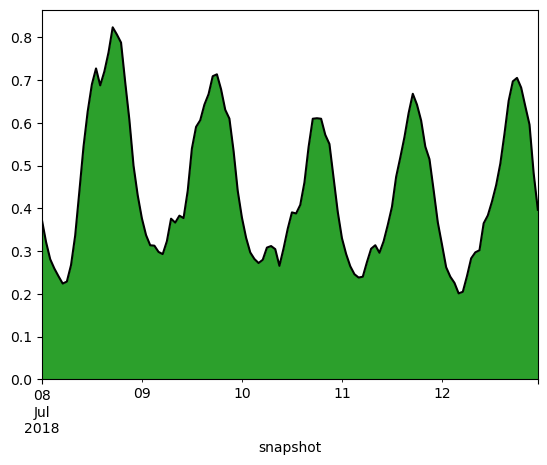

In [33]:
fig, ax = plt.subplots()
time = '2018-07-08'
n.generators_t.p.loc[time:'2018-07-12'].plot.area(ax=ax, lw=0, legend=False)
n.loads_t.p_set.loc[time:'2018-07-12'].plot(ax=ax, color='k', legend=False)


## Model Version: Policy Simulation

The purpose of this simulation is to test the effect of price reductions and net metering on solar penetration.

In [51]:
n.storage_units

,bus,control,type,p_nom,p_nom_mod,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,...,state_of_charge_initial_per_period,state_of_charge_set,cyclic_state_of_charge,cyclic_state_of_charge_per_period,max_hours,efficiency_store,efficiency_dispatch,standing_loss,inflow,p_nom_opt
StorageUnit,,,,,,,,,,,,,,,,,,,,,
Residential Battery Storage,Residential,PQ,,0.0,0.0,True,0.0,inf,-1.0,1.0,...,False,NaN,False,True,2.5,1.0,1.0,0.0,0.0,-0.0


In [74]:
data = {'discount':[],
        'battery_discount':[],
        'percent_retail_price':[],
        'solar_capacity':[],
        'battery_capacity':[],
        'objective_value':[],
        }


delta = 0.02
discounts = np.arange(0, 1+delta, delta)
# discounts = [0.8]
# retail_prices = np.linspace(0, 1, 5)
retail_prices = [0]
battery_discounts = [0, 0.25, 0.5, 0.75, 1]
for discount in discounts:
    # for pct_retail in retail_prices:
    for battery_discount in battery_discounts:
        pct_retail = 0
        n.generators.loc['ResPV', 'capital_cost'] = costs.at['ResPV','annualized_cost'] * (1-discount)
        n.storage_units.loc['Residential Battery Storage', 'capital_cost'] = costs.at['Residential Battery Storage','annualized_cost'] * (1-battery_discount)
        n.generators.loc['Net metering Residential', 'marginal_cost'] = retail_price*pct_retail
        n.optimize(solver_name='highs')
        
        data['discount'].append(discount)
        data['battery_discount'].append(battery_discount)
        data['solar_capacity'].append(np.abs(n.generators.p_nom_opt['ResPV']))
        data['battery_capacity'].append(np.abs(n.storage_units.p_nom_opt['Residential Battery Storage']))
        data['percent_retail_price'].append(pct_retail)
        data['objective_value'].append(n.objective)

Index(['Residential'], dtype='object', name='Bus')
Index(['Residential'], dtype='object', name='Bus')
c:\Users\SDotson\AppData\Local\miniforge3\envs\pypsa-illinois02\Lib\site-packages\linopy\common.py:147: UserWarning:

coords for dimension(s) ['Generator'] is not aligned with the pandas object. Previously, the indexes of the pandas were ignored and overwritten in these cases. Now, the pandas object's coordinates are taken considered for alignment.

INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 71.99it/s]
INFO:linopy.io: Writing time: 0.78s
INFO:linopy.solvers:Log file at C:\Users\SDotson\AppData\Local\Temp\highs.log
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52564 primals, 122648 duals
Objective: 4.67e+05
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints G

<Axes: xlabel='snapshot'>

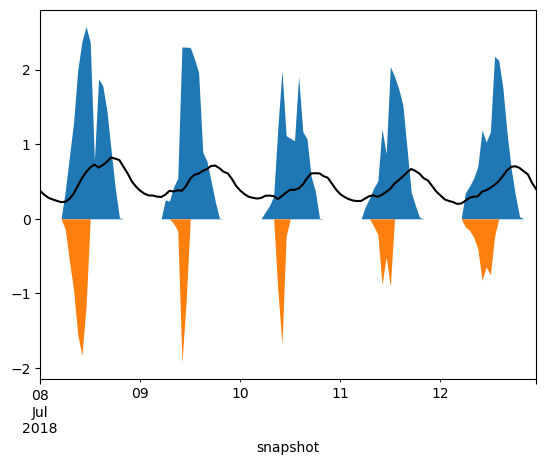

In [75]:
fig, ax = plt.subplots()
time = '2018-07-08'
n.generators_t.p.loc[time:'2018-07-12'].plot.area(ax=ax, lw=0, legend=False)
n.loads_t.p_set.loc[time:'2018-07-12'].plot(ax=ax, color='k', legend=False)

In [76]:
results_df_large = pd.DataFrame(data)
results_df_large

,discount,battery_discount,percent_retail_price,solar_capacity,battery_capacity,objective_value
0,0.0,0.00,0,0.000,0.000000,466950.487985
1,0.0,0.25,0,0.000,0.000000,466950.487985
2,0.0,0.50,0,0.000,0.000000,466950.487985
3,0.0,0.75,0,0.000,0.000000,466950.487985
4,0.0,1.00,0,0.000,16.777729,466950.487985
...,...,...,...,...,...,...
250,1.0,0.00,0,2.807,0.000000,253874.061694
251,1.0,0.25,0,2.807,0.000000,253874.061694
252,1.0,0.50,0,2.807,0.000000,253874.061694
253,1.0,0.75,0,2.807,1.069640,226578.389655


In [43]:
import seaborn as sb

In [77]:
results_df_large = results_df_large.assign(solar_penetration=results_df_large['solar_capacity'] / n.generators.p_nom_max.ResPV)


In [45]:
results_df_large = pd.read_csv('simulation_data.csv', index_col=0)

In [ ]:
fig, ax = plt.subplots()
sb.lineplot(data=results_df_large[['discount','solar_penetration','battery_discount']]*100,
            x='discount',
            y='solar_penetration',
            ax=ax,
            hue='battery_discount',
            palette='tab20')

ax.set_ylabel("% of total electricity covered by solar")
ax.set_xlabel("Reduction in Capital Cost\n (%)")
ax.legend(title='Net Metering Price\n (% Retail Price)')

ax.minorticks_on()
ax.grid(which='major')
ax.grid(which='minor', alpha=0.2)
ax.set_ylim(0,1.05*100)
ax.set_xlim(0,1.0*100)

ax.axvline(x=50, color='tab:red', linestyle='--')

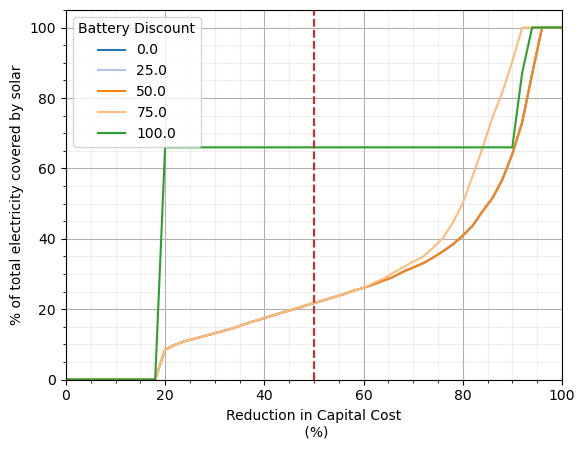

In [87]:
fig, ax = plt.subplots()
sb.lineplot(data=results_df_large[['discount','solar_penetration','battery_discount']]*100,
            x='discount',
            y='solar_penetration',
            ax=ax,
            hue='battery_discount',
            palette='tab20')

ax.set_ylabel("% of total electricity covered by solar")
ax.set_xlabel("Reduction in Capital Cost\n (%)")
ax.legend(title='Battery Discount')

ax.minorticks_on()
ax.grid(which='major')
ax.grid(which='minor', alpha=0.2)
ax.set_ylim(0,1.05*100)
ax.set_xlim(0,1.0*100)

ax.axvline(x=50, color='tab:red', linestyle='--')

In [ ]:
results_df_large['d']

,discount,battery_discount,percent_retail_price,solar_capacity,battery_capacity,objective_value,solar_penetration
0,0.00,0,0,0.000,0.000000,466950.487985,0.0
1,0.00,1,0,0.000,16.777729,466950.487985,0.0
2,0.02,0,0,0.000,0.000000,466950.487985,0.0
3,0.02,1,0,0.000,16.777729,466950.487985,0.0
4,0.04,0,0,0.000,0.000000,466950.487985,0.0
...,...,...,...,...,...,...,...
97,0.96,1,0,2.807,61.966131,59572.301747,1.0
98,0.98,0,0,2.807,0.000000,269393.746701,1.0
99,0.98,1,0,2.807,61.966131,44052.616739,1.0
100,1.00,0,0,2.807,0.000000,253874.061694,1.0


In [84]:
results_df_large.loc[results_df_large['battery_capacity'] > 2]

,discount,battery_discount,percent_retail_price,solar_capacity,battery_capacity,objective_value,solar_penetration
4,0.00,1.0,0,0.000000,16.777729,466950.487985,0.000000
9,0.02,1.0,0,0.000000,16.777729,466950.487985,0.000000
14,0.04,1.0,0,0.000000,16.777729,466950.487985,0.000000
19,0.06,1.0,0,0.000000,16.777729,466950.487985,0.000000
24,0.08,1.0,0,0.000000,16.777729,466950.487985,0.000000
29,0.10,1.0,0,0.000000,16.777729,466950.487985,0.000000
34,0.12,1.0,0,0.000000,16.777729,466950.487985,0.000000
39,0.14,1.0,0,0.000000,16.777729,466950.487985,0.000000
44,0.16,1.0,0,0.000000,16.777729,466950.487985,0.000000
49,0.18,1.0,0,0.000000,16.777729,466950.487985,0.000000


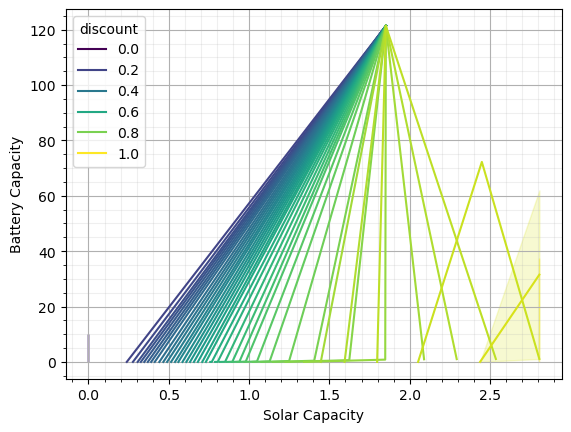

In [85]:
fig, ax = plt.subplots()
sb.lineplot(data=results_df_large[['discount', 'battery_discount','solar_capacity', 'battery_capacity']],
            x='solar_capacity',
            y='battery_capacity',
            ax=ax,
            hue='discount',
            # style='battery_discount',
            palette='viridis')

ax.set_xlabel("Solar Capacity")
ax.set_ylabel("Battery Capacity")
# ax.legend(title='Net Metering Price\n (% Retail Price)')

ax.minorticks_on()
ax.grid(which='major')
ax.grid(which='minor', alpha=0.2)
# ax.set_ylim(0,4)
# ax.set_xlim(0,1.0*100)

In [363]:
results_df_large['solar_penetration'] = results_df_large['solar_penetration'].round(2)

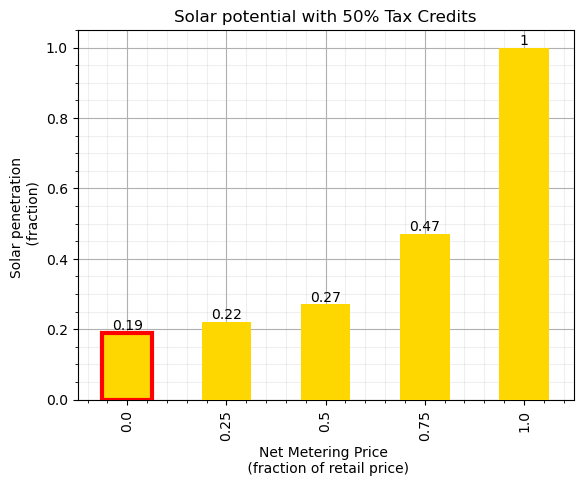

In [368]:
ax = results_df_large.loc[results_df_large['discount']==0.5, ['percent_retail_price','solar_penetration']].plot.bar(x='percent_retail_price',
                                                                                                               y='solar_penetration',
                                                                                                               legend=False,
                                                                                                               zorder=3,
                                                                                                               color='gold')
ax.set_xlabel('Net Metering Price \n (fraction of retail price)')
ax.set_ylabel("Solar penetration \n (fraction)")
ax.set_title("Solar potential with 50% Tax Credits")

ax.minorticks_on()
ax.grid(which='major', zorder=0)
ax.grid(which='minor', alpha=0.2)

ax.patches[0].set_edgecolor('red')
ax.patches[0].set_linewidth(3)
ax.bar_label(ax.containers[0])
plt.show()

In [279]:
results_df_large.describe()

,discount,percent_retail_price,solar_capacity,battery_capacity,objective_value,solar_penetration
count,255.000000,255.000000,255.000000,255.0,255.000000,255.000000
mean,0.500000,0.500000,1.217456,0.0,382392.224079,0.433721
std,0.294971,0.354249,1.236635,0.0,117536.626041,0.440554
min,0.000000,0.000000,0.000000,0.0,66.099781,0.000000
25%,0.240000,0.250000,0.000000,0.0,324929.125859,0.000000
50%,0.500000,0.500000,0.757254,0.0,448625.587086,0.269774
75%,0.760000,0.750000,2.807000,0.0,466950.487985,1.000000
max,1.000000,1.000000,2.807000,0.0,466950.487985,1.000000


In [280]:
results_df_large = results_df_large.assign(lcoe=results_df_large['objective_value'] / n.loads_t.p_set.sum().values[0] / 1000)

(0.0, 1.0)

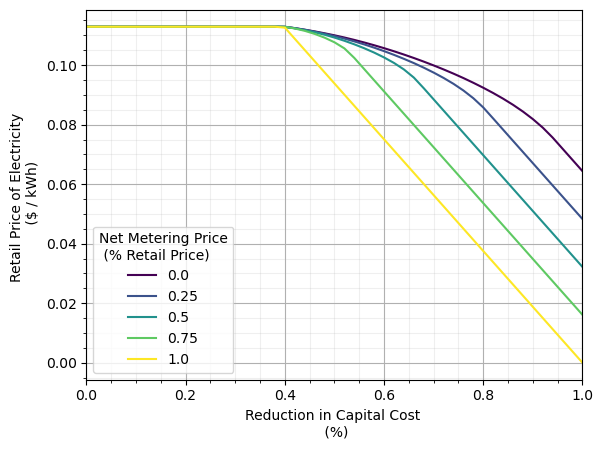

In [281]:
fig, ax = plt.subplots()
sb.lineplot(data=results_df_large,
            x='discount',
            y='lcoe',
            ax=ax,
            hue='percent_retail_price',
            palette='viridis'
            )

ax.set_ylabel("Retail Price of Electricity \n ($ / kWh)")
ax.set_xlabel("Reduction in Capital Cost \n (%)")
ax.legend(title='Net Metering Price\n (% Retail Price)')

ax.minorticks_on()
ax.grid(which='major')
ax.grid(which='minor', alpha=0.2)
# ax.set_ylim(0,1.005)
ax.set_xlim(0,1.0)

results_df_large.to_csv("simulation_data.csv")

In [148]:
(costs.at['ResPV','annualized_cost'] * 2.807) / load_resampled.sum()

0.18761865362970692

## Model Version: Net Metering

At this moment, the model

* uses the sticker price for rooftop solar from NREL's ATB
* applies 100% retail price for net metering
* does NOT include residential storage

In [23]:
n.generators.loc['Net metering Residential', 'marginal_cost'] = retail_price*1.0

In [24]:
n.optimize(solver_name='highs')

INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 71.10it/s]
INFO:linopy.io: Writing time: 0.62s
INFO:linopy.solvers:Log file at C:\Users\sdotson\AppData\Local\Temp\highs.log
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52564 primals, 122645 duals
Objective: 4.67e+05
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


('ok', 'optimal')

In [25]:
n.statistics()

c:\Users\sdotson\AppData\Local\miniforge3\envs\kansas-city\lib\site-packages\pypsa\statistics.py:308: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



,,Optimal Capacity,Installed Capacity,Supply,Withdrawal,Dispatch,Transmission,Capacity Factor,Curtailment,Capital Expenditure,Operational Expenditure,Revenue,Market Value
Generator,grid,1.430806,0.0,4135.96535,0.00000,4135.96535,0.0,0.329983,0.0,0.0,466950.487985,466950.487985,112.9
Load,-,0.000000,0.0,0.00000,4135.96535,-4135.96535,0.0,NaN,0.0,0.0,0.000000,-466950.487985,NaN


In [26]:
model_lcoe_2 = n.objective / n.loads_t.p_set.sum()
model_lcoe_2

Load
Load Residential    112.9
dtype: float64

<Axes: xlabel='snapshot'>

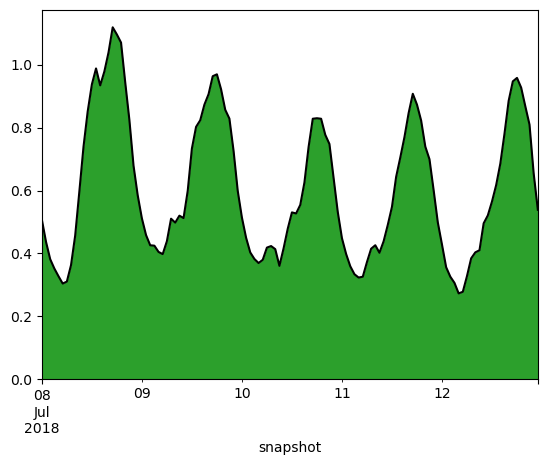

In [27]:
fig, ax = plt.subplots()
time = '2018-07-08'
n.generators_t.p.loc[time:'2018-07-12'].plot.area(ax=ax, lw=0, legend=False)
n.loads_t.p_set.loc[time:'2018-07-12'].plot(ax=ax, color='k', legend=False)


## Model Version: Tax Credits

At this moment, the model

* reduces the price for rooftop solar by applying federal tax credits.
* does NOT pay for net metering
* does NOT include residential storage

Apply the Residential Renewable Energy Tax Credit

[DSIRE Data on the RRETC](https://programs.dsireusa.org/system/program/detail/1235/residential-renewable-energy-tax-credit) -- solar and storage each get a 30% tax credit. 

Apply the Investment Tax Credit (ITC)

[EPA Data on ITC](https://www.epa.gov/green-power-markets/summary-inflation-reduction-act-provisions-related-renewable-energy) -- qualified residential units in a low-income area recieve +20%.

[Homeowner's Guide to Federal Tax Credits](https://www.energy.gov/eere/solar/homeowners-guide-federal-tax-credit-solar-photovoltaics).

This will be implemented as a direct 50% cost reduction.

In [28]:
# reset the price of net metering
n.generators.loc['Net metering Residential', 'marginal_cost'] = retail_price*0.0

In [29]:
rretc_credit = 0.5

In [30]:
n.storage_units

attribute,bus,control,type,p_nom,p_nom_mod,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,...,state_of_charge_initial_per_period,state_of_charge_set,cyclic_state_of_charge,cyclic_state_of_charge_per_period,max_hours,efficiency_store,efficiency_dispatch,standing_loss,inflow,p_nom_opt
StorageUnit,,,,,,,,,,,,,,,,,,,,,
Residential Battery Storage,Residential,PQ,,0.0,0.0,True,0.0,inf,-1.0,1.0,...,False,NaN,False,True,2.5,1.0,1.0,0.0,0.0,-0.0


In [31]:
n.generators.loc['ResPV', 'capital_cost'] *= (1-rretc_credit)
n.storage_units.loc['Residential Battery Storage', 'capital_cost'] *= (1-rretc_credit)

In [32]:
n.optimize(solver_name='highs')

INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 73.29it/s]
INFO:linopy.io: Writing time: 0.7s
INFO:linopy.solvers:Log file at C:\Users\sdotson\AppData\Local\Temp\highs.log
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52564 primals, 122645 duals
Objective: 4.17e+05
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


('ok', 'optimal')

In [33]:
n.statistics()

c:\Users\sdotson\AppData\Local\miniforge3\envs\kansas-city\lib\site-packages\pypsa\statistics.py:308: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



Optimal Capacity  Installed Capacity       Supply  \
Generator grid                  1.342852                 0.0  2964.049410   
          net metering          0.669086                 0.0     0.000000   
          solar                 0.947609                 0.0  1396.053259   
Load      -                     0.000000                 0.0     0.000000   

                        Withdrawal     Dispatch  Transmission  \
Generator grid             0.00000  2964.049410           0.0   
          net metering   224.13732  -224.137320           0.0   
          solar            0.00000  1396.053259           0.0   
Load      -             4135.96535 -4135.965350           0.0   

                        Capacity Factor   Curtailment  Capital Expenditure  \
Generator grid                 0.251973  0.000000e+00               0.0000   
          net metering         0.038241  0.000000e+00               0.0000   
          solar                0.168178  3.914040e-10           82394.7361   
Load      -                         NaN  0.000000e+00               0.0000   

                        Operational Expenditure        Revenue  Market Value  
Generator grid                    334641.178424  334641.178424    112.900000  
          net metering                 0.000000       0.000000      0.000000  
          solar                        0.000000   82394.736100     59.019766  
Load      -                            0.000000 -417035.914525           NaN

Calculate the LCOE

In [34]:
model_lcoe_3 = n.objective / n.loads_t.p_set.sum().values[0]
model_lcoe_3

100.83157842499818

Calculate the electricity price reduction

In [35]:
np.abs((100.831578 - 112.9)/112.9)*100

10.689479185119586

Looks like almost a 10.7% reduction in electricity cost.

<Axes: xlabel='snapshot'>

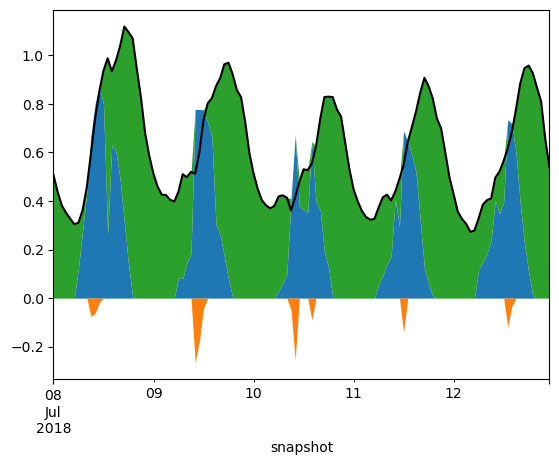

In [36]:
fig, ax = plt.subplots()
time = '2018-07-08'
n.generators_t.p.loc[time:'2018-07-12'].plot.area(ax=ax, lw=0, legend=False)
n.loads_t.p_set.loc[time:'2018-07-12'].plot(ax=ax, color='k', legend=False)

## Model Version: Net Metering + Tax Credits

At this moment, the model

* reduces the price for rooftop solar by applying federal tax credits.
* Applies 50% retail price for net metering
* does NOT include residential storage

In [37]:
n.generators.marginal_cost

Generator
ResPV                         0.0
Net metering Residential      0.0
Evergy Import               112.9
Name: marginal_cost, dtype: float64

In [38]:
n.generators.loc['Net metering Residential', 'marginal_cost'] = retail_price*0.5

In [39]:
n.generators.marginal_cost

Generator
ResPV                         0.00
Net metering Residential     56.45
Evergy Import               112.90
Name: marginal_cost, dtype: float64

In [40]:
n.optimize(solver_name='highs')

INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 60.33it/s]
INFO:linopy.io: Writing time: 0.71s
INFO:linopy.solvers:Log file at C:\Users\sdotson\AppData\Local\Temp\highs.log
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52564 primals, 122645 duals
Objective: 3.77e+05
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


('ok', 'optimal')

In [41]:
n.statistics()

c:\Users\sdotson\AppData\Local\miniforge3\envs\kansas-city\lib\site-packages\pypsa\statistics.py:308: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



Optimal Capacity  Installed Capacity       Supply  \
Generator grid                  1.331491                 0.0  2358.485524   
          net metering          2.505756                 0.0     0.000000   
          solar                 2.807000                 0.0  4135.379878   
Load      -                     0.000000                 0.0     0.000000   

                         Withdrawal     Dispatch  Transmission  \
Generator grid             0.000000  2358.485524           0.0   
          net metering  2357.900052 -2357.900052           0.0   
          solar            0.000000  4135.379878           0.0   
Load      -             4135.965350 -4135.965350           0.0   

                        Capacity Factor   Curtailment  Capital Expenditure  \
Generator grid                 0.202205  0.000000e+00             0.000000   
          net metering         0.107419  0.000000e+00             0.000000   
          solar                0.168178  1.159408e-09        244069.150984   
Load      -                         NaN  0.000000e+00             0.000000   

                        Operational Expenditure        Revenue  Market Value  
Generator grid                    266273.015698  266273.015698    112.900000  
          net metering           -133103.457958 -133103.457958           NaN  
          solar                        0.000000  255898.612865     61.880316  
Load      -                            0.000000 -389068.170605           NaN

In [42]:
model_lcoe_4 = n.objective / n.loads_t.p_set.sum().values[0]
model_lcoe_4

91.20934940819072

<Axes: xlabel='snapshot'>

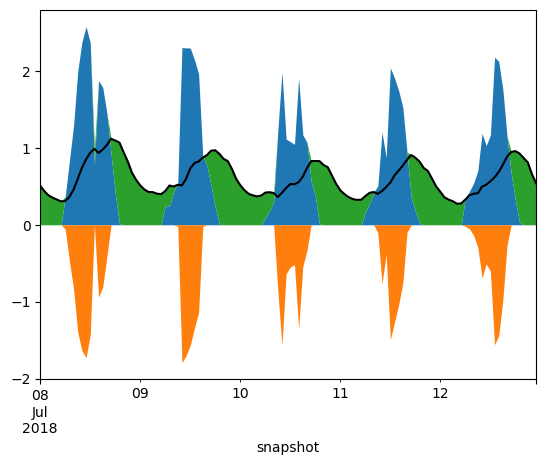

In [43]:
fig, ax = plt.subplots()
time = '2018-07-08'
n.generators_t.p.loc[time:'2018-07-12'].plot.area(ax=ax, lw=0, legend=False)
n.loads_t.p_set.loc[time:'2018-07-12'].plot(ax=ax, color='k', legend=False)

## Model Version: Net Metering + Tax Credits

At this moment, the model

* reduces the price for rooftop solar by applying federal tax credits.
* Applies 99% retail price for net metering
* does NOT include residential storage

In [44]:
n.generators.loc['Net metering Residential', 'marginal_cost'] = retail_price*1.00

In [45]:
n.generators.marginal_cost

Generator
ResPV                         0.0
Net metering Residential    112.9
Evergy Import               112.9
Name: marginal_cost, dtype: float64

In [46]:
n.generators.loc['ResPV', 'p_nom_max'] = 2.807

In [47]:
n.optimize(solver_name='highs')

INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 69.62it/s]
INFO:linopy.io: Writing time: 0.63s
INFO:linopy.solvers:Log file at C:\Users\sdotson\AppData\Local\Temp\highs.log
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52564 primals, 122645 duals
Objective: 2.44e+05
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


('ok', 'optimal')

In [48]:
n.statistics()

c:\Users\sdotson\AppData\Local\miniforge3\envs\kansas-city\lib\site-packages\pypsa\statistics.py:308: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



Optimal Capacity  Installed Capacity       Supply  \
Generator grid                  1.331491                 0.0  2358.485524   
          net metering          2.505756                 0.0     0.000000   
          solar                 2.807000                 0.0  4135.379878   
Load      -                     0.000000                 0.0     0.000000   

                         Withdrawal     Dispatch  Transmission  \
Generator grid             0.000000  2358.485524           0.0   
          net metering  2357.900052 -2357.900052           0.0   
          solar            0.000000  4135.379878           0.0   
Load      -             4135.965350 -4135.965350           0.0   

                        Capacity Factor   Curtailment  Capital Expenditure  \
Generator grid                 0.202205  0.000000e+00             0.000000   
          net metering         0.107419  0.000000e+00             0.000000   
          solar                0.168178  1.159408e-09        244069.150984   
Load      -                         NaN  0.000000e+00             0.000000   

                        Operational Expenditure        Revenue  Market Value  
Generator grid                    266273.015698  266273.015698         112.9  
          net metering           -266206.915917 -266206.915917           NaN  
          solar                        0.000000  466884.388204         112.9  
Load      -                            0.000000 -466950.487985           NaN

In [49]:
model_lcoe_5 = n.objective / n.loads_t.p_set.sum().values[0]
model_lcoe_5

59.02739266934207

<Axes: xlabel='snapshot'>

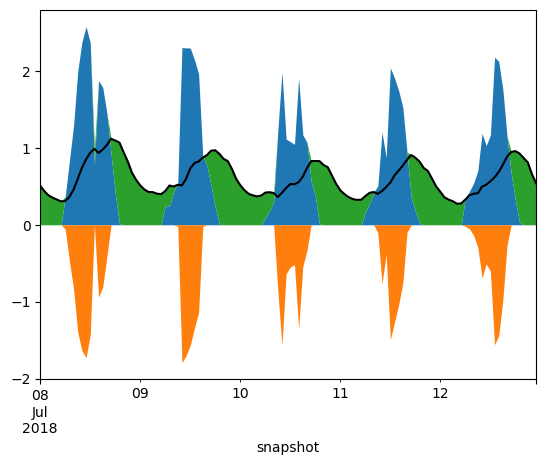

In [50]:
fig, ax = plt.subplots()
time = '2018-07-08'
n.generators_t.p.loc[time:'2018-07-12'].plot.area(ax=ax, lw=0, legend=False)
n.loads_t.p_set.loc[time:'2018-07-12'].plot(ax=ax, color='k', legend=False)

## Basic Analysis: How much solar capacity is required to meet 100% demand?

In [171]:
solar_100 = ghi / ghi.sum() * load_resampled.sum()

In [175]:
net_load = load_resampled - solar_100

In [178]:
solar_cap = solar_100.max()
solar_cap

2.8073974047750987

In [179]:
total_unmet_load = net_load.where(net_load>0).sum()

In [181]:
total_unmet_load*retail_price

266266.65710289485

In [285]:
discounts = np.linspace(0,1,20)
full_solar_cost_data = np.array([(costs.at['ResPV','annualized_cost'] * (1-discount) * solar_cap 
                                  + total_unmet_load*retail_price) 
                                 / load_resampled.sum() 
                                 for discount in discounts])

In [302]:
retail_price/1e3

0.1129

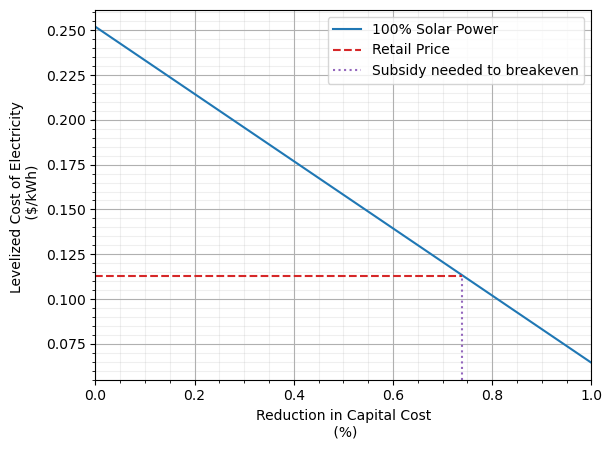

In [313]:
fig, ax = plt.subplots()
y1 = ax.plot(discounts, full_solar_cost_data/1e3, label='100% Solar Power')
y2 = ax.axhline(y=retail_price/1e3, xmax=0.74, color='tab:red', linestyle='--', label='Retail Price')
y2 = ax.axvline(x=0.74, ymax=0.1129*2.5, linestyle=':', color='tab:purple', label='Subsidy needed to breakeven')
ax.set_xlim(0,1)
ax.set_ylabel("Levelized Cost of Electricity \n ($/kWh)")
ax.set_xlabel("Reduction in Capital Cost\n (%)")
ax.minorticks_on()
ax.grid(which='major')
ax.grid(which='minor',alpha=0.2)
ax.legend()

(0.0, 1.0)

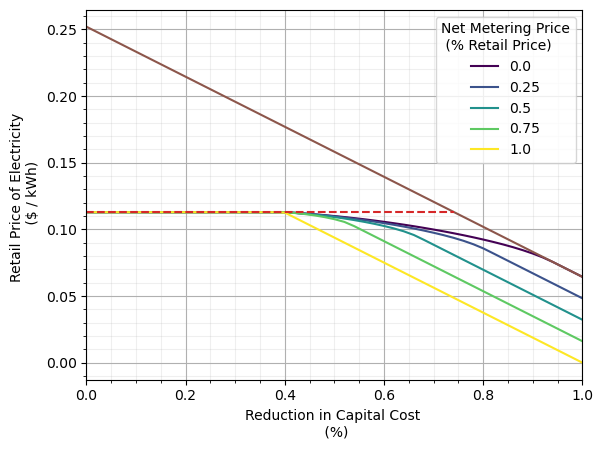

In [287]:
fig, ax = plt.subplots()
sb.lineplot(data=results_df_large,
            x='discount',
            y='lcoe',
            ax=ax,
            hue='percent_retail_price',
            palette='viridis'
            )

y1 = ax.plot(discounts, full_solar_cost_data/1000)
y2 = ax.axhline(y=retail_price/1000, xmax=0.74, color='tab:red', linestyle='--')

ax.set_ylabel("Retail Price of Electricity \n ($ / kWh)")
ax.set_xlabel("Reduction in Capital Cost \n (%)")
ax.legend(title='Net Metering Price\n (% Retail Price)')

ax.minorticks_on()
ax.grid(which='major')
ax.grid(which='minor', alpha=0.2)
# ax.set_ylim(0,1.005)
ax.set_xlim(0,1.0)

In [229]:
lcoe_costs = full_solar_cost_data.copy()
lcoe_costs[lcoe_costs>=retail_price] = retail_price

(0.0, 1.0)

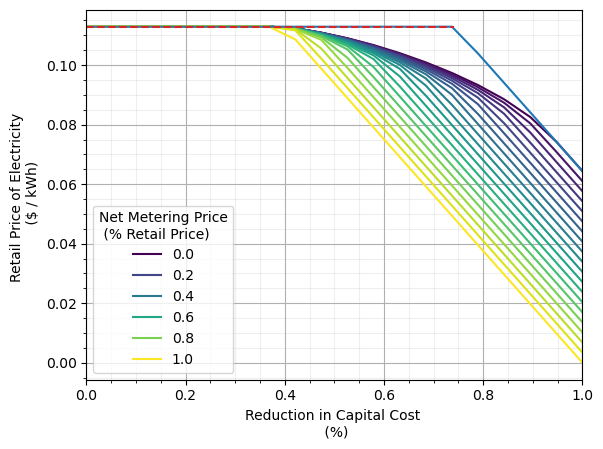

In [230]:
fig, ax = plt.subplots()
sb.lineplot(data=results_df_large,
            x='discount',
            y='lcoe',
            ax=ax,
            hue='percent_retail_price',
            palette='viridis'
            )

y1 = ax.plot(discounts, lcoe_costs/1000)
y2 = ax.axhline(y=retail_price/1000, xmax=0.74, color='tab:red', linestyle='--')

ax.set_ylabel("Retail Price of Electricity \n ($ / kWh)")
ax.set_xlabel("Reduction in Capital Cost \n (%)")
ax.legend(title='Net Metering Price\n (% Retail Price)')

ax.minorticks_on()
ax.grid(which='major')
ax.grid(which='minor', alpha=0.2)
# ax.set_ylim(0,1.005)
ax.set_xlim(0,1.0)

In [243]:
((lcoe_costs/1000) - results_df_large.loc[results_df_large['percent_retail_price']==0].lcoe.values).sum()*100

6.660796450820109

(0.0, 1.0)

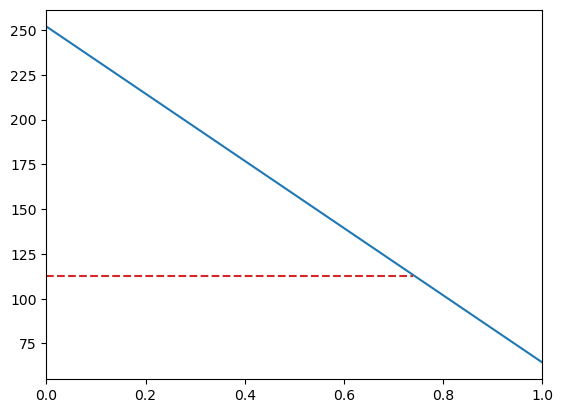

In [214]:
fig, ax = plt.subplots()
y1 = ax.plot(discounts, full_solar_cost_data)
y2 = ax.axhline(y=retail_price, xmax=0.74, color='tab:red', linestyle='--')
ax.set_xlim(0,1)

In [247]:
costs.at['ResPV', 'annualized_cost'] * 2.807 * 20 / 1e6

15.51968500751449

In [248]:
costs.at['ResPV', 'OCC'] * 2.807 /  1e6

7.384904875130196